<a href="https://colab.research.google.com/github/Flopezc4/AI-Fred/blob/main/Cuaderno_Python/Open_cv_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---



# Parte 1 -- Detectar patente  
Detectar la patente atraves del uso de filtro y contornos, para posteriormente poder guardar unicamente la patente de una imagen


In [ ]:
!pip install opencv-contrib-python-headless
!pip install matplotlib
!pip install scikit-image
!pip install -q keras-ocr
!pip install numpy

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras_ocr
import skimage



---



## Carga de imagen

(2448, 3264, 3)


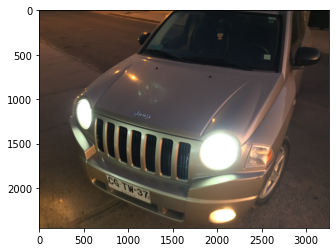

In [77]:
img = cv2.imread('/content/drive/MyDrive/IMG_Caso_de_uso/auto47.JPG')
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 1° Filtro Gris
Pasamos la imagen a blanco y negro, con la funcion cvtColor de cv2, es decir pasa de 3 canales a solo 1

(2448, 3264)


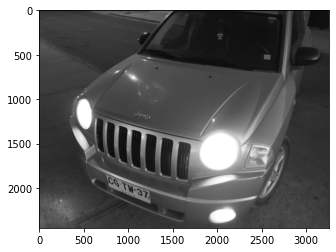

In [78]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray, cmap='gray')
plt.show()

## 2° Filtro Threshold
Si el pixel es mayor a 175 lo dejamos a 255, nos quedamos con una imagen con valores de 0 o 255

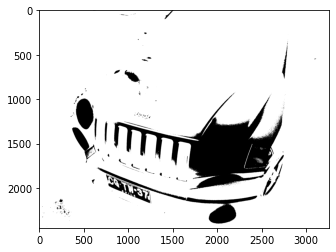

In [88]:
th = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(th, cmap='gray')
plt.show()

In [ ]:
# Comparacion con la imagen antigua y la nueva
[gray,th]

## 3° Filtro para obtener los contornos
FindContours devuelve los contornos de las formas de una imagen, se le aplica esta función a la imagen threshold

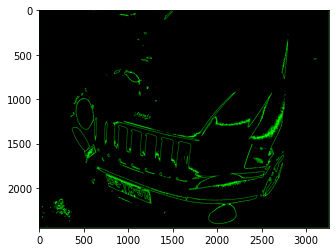

In [89]:
contours = cv2.findContours(th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
canvas = np.zeros_like(img)
cv2.drawContours(canvas , contours, -1, (0, 255, 0), 2)
#plt.axis('off')
plt.imshow(canvas, cmap='gray')
plt.show()


## 4° Eliminar los contornos que no son candidatos
Por el caso de uso que usaremos podemos determinar que la patente tiene aproximadamente X tamaño por lo cual los contornos muy grande se elimina al igual que los contornos muy pequeños.



*   **Largo** : 360 milimetros
*   **Ancho** : 130 milimetros
*   tipo de letra Fe-Schrift o Fälschungserschnerende Schrift de un alto de 70 milímetros
*   El símbolo del escudo o logotipo no podrán ser mayores a 20 por 20 milímetros
*   Letras de la palabra "Chile" serán del tipo Fe-Schrift o Fälschungserschnerende Schrift de un alto
de 15 milímetros
*   El punto que separa en grupos de a dos a las letras de las combinaciones o de cuatro letras y
dos dígitos, no será mayor de 10 milímetros de diámetro.




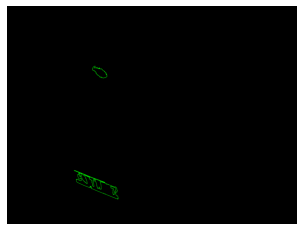

In [102]:
# Patente chilena ratio = 360 / 130 = 2.769230769
candidates = []
ratio = 3.2
min_w = 100
max_w = 500


min_h = 100
max_h = 300

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h
    # SI el aspecratio es similar Y el ancho Y el alto es Similar , es candidato
    #np.isclose(aspect_ratio, ratio, atol=1.0) and
    if ( (max_w > w > min_w) and (max_h > h > min_h) and (w > h)):
        candidates.append(cnt)

# redibujamos los contornos que nos quedan, despues de aplicar un filtro

canvas = np.zeros_like(img)
cv2.drawContours(canvas , candidates, -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

In [103]:
for cnt in candidates:
    print(cv2.boundingRect(cnt))

(778, 1873, 474, 296)
(755, 1845, 349, 140)
(962, 674, 165, 136)


## 5° Filtro de contornos 2
Para los contornos que se asimilen en tamaño, filtramos por posición, la patente de un auto tipicamente se encuentra en la parte inferior central del auto.

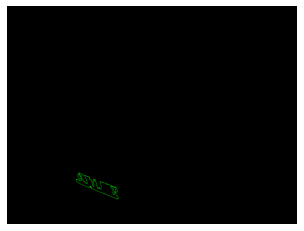

In [104]:
ys = []
for cnt in candidates:
    x, y, w, h = cv2.boundingRect(cnt)
    ys.append(y)

license = candidates[np.argmax(ys)]


canvas = np.zeros_like(img)
cv2.drawContours(canvas , [license], -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);



## Cortar
Una vez encontrado nuestro contorno lo cortamos.

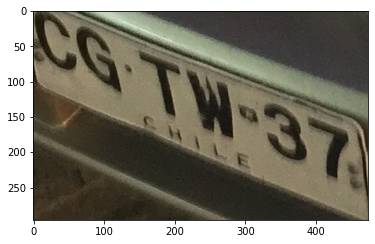

In [93]:
x, y, w, h = cv2.boundingRect(license)
cropped = gray[y:y+h,x:x+w]
x, y, w, h = cv2.boundingRect(license)
cropped2 = img[y:y+h,x:x+w]
plt.imshow(cv2.cvtColor(cropped2, cv2.COLOR_BGR2RGB))
plt.show()

## Volvemos a aplicar el filtro gris 
Ahora solamente a la imagen que obtenemos.

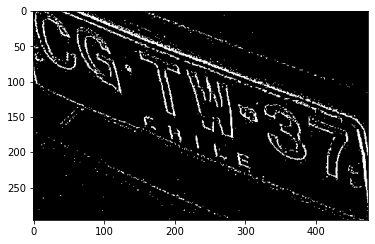

In [94]:
thresh_cropped = cv2.adaptiveThreshold(cropped, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 13)
plt.imshow(thresh_cropped, cmap='gray')
plt.show()

## Skimage limpia los contornos
Para obtener una mejor imagen.

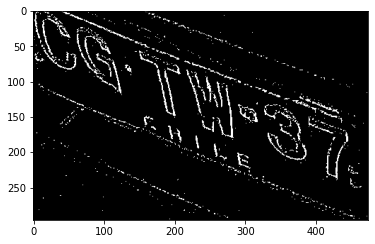

In [95]:
clear_border = skimage.segmentation.clear_border(thresh_cropped)
plt.imshow(clear_border, cmap='gray')
plt.show()

## Invertimos los colores

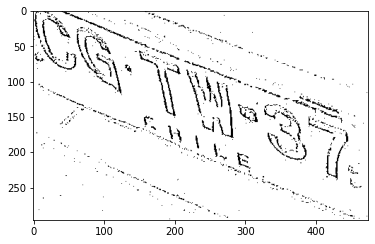

In [96]:
final = cv2.bitwise_not(clear_border)
plt.imshow(final, cmap='gray')
plt.show()

## Finalmente Obtenomos los dijitos y nos faltaria un modelo que dejecte los caracteres 

In [ ]:
cv2.imwrite('CGTW37.png',final)

True

# Parte 2 -- Detectar carcteres

In [ ]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
images = keras_ocr.tools.read('/content/CGTW37.png') 

In [ ]:
prediction_groups = pipeline.recognize([images])

1/1 [==============================] - 4s 4s/step


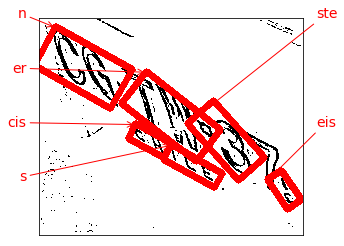

In [ ]:
keras_ocr.tools.drawAnnotations(image=images, predictions=prediction_groups[0])

## Prueba TESERAKE ???

## Prueba open orc ???


## Prueba Modelo propio ??